In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pyemma
import glob
import pandas as pd

import nglview
import mdtraj
from threading import Timer
from nglview.player import TrajectoryPlayer

***
### Feature Selection

In [3]:
# Get topology and trajectory files. 
# Split trajectories into training set [:-1] and test set [-1]

gro = './data/peptide.gro'
trj = glob.glob('./data/md_1us_*_noPBC.xtc')
train_files = trj[:-1]
test_file = trj[-1]
print('Training files:', *train_files, '\nTest files:', test_file)
assert set(train_files) & set(test_file) == set()

Training files: ./data/md_1us_1_noPBC.xtc ./data/md_1us_2_noPBC.xtc 
Test files: ./data/md_1us_0_noPBC.xtc


In [ ]:
# Have a look at the structure

widget = nglview.show_mdtraj(mdtraj.load(gro))
p = TrajectoryPlayer(widget)
widget.add_ball_and_stick()
p.spin = True
def stop_spin():
    p.spin = False
    widget.close()
Timer(30, stop_spin).start()
widget

Obtaining file info:   0%|                                                                        | 0/3 [00:00…

getting output of FeatureReader:   0%|                                                            | 0/3 [00:00…

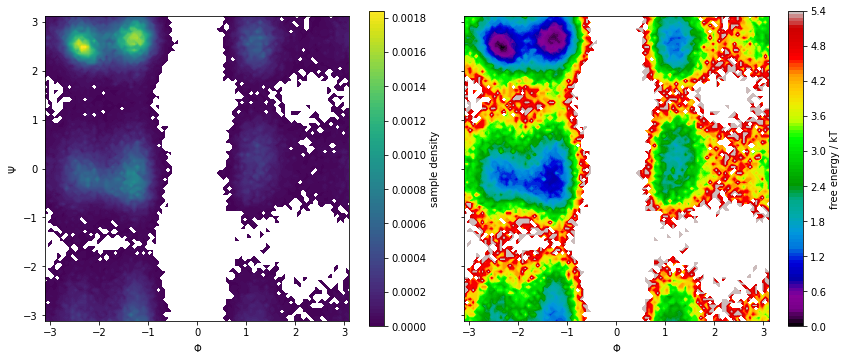

In [43]:
# Ramachandran plot and free energy plot 

feat_torsion = pyemma.coordinates.featurizer(gro)
feat_torsion.add_backbone_torsions(periodic=False)
reader_torsion = pyemma.coordinates.source(trj, features = feat_torsion)
data_plot = reader_torsion.get_output(stride = 3)

phi = np.concatenate(data_plot[0][:,::2])
psi = np.concatenate(data_plot[0][:,1::2])

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
pyemma.plots.plot_density(phi, psi, ax=axes[0])
pyemma.plots.plot_free_energy(phi, psi, ax=axes[1], legacy=False)
for ax in axes.flat:
    ax.set_xlabel('$\Phi$')
    ax.set_aspect('equal')
axes[0].set_ylabel('$\Psi$')
fig.tight_layout()
plt.savefig(fname = './figures/Ramachandran.png')

In [31]:
# Select features by comparing VAMP scores at different lag times 
feat = pyemma.coordinates.featurizer(gro)
stride = 10

# backbone torsions
feat.active_features = []
feat.add_backbone_torsions(periodic=False)
data_backbone = pyemma.coordinates.load(train_files, features=feat, stride = stride)
data_backbone_test = pyemma.coordinates.load(test_file, features=feat, stride = stride)
print('Backbone torsions dimension: ',feat.dimension())

# ca distances
feat.active_features = []
feat.add_distances_ca(periodic=False)
data_ca = pyemma.coordinates.load(train_files, features=feat, stride = stride)
data_ca_test = pyemma.coordinates.load(test_file, features=feat, stride = stride)
print('Ca distances dimension: ',feat.dimension())

# sidechain torsions
feat.active_features = []
feat.add_sidechain_torsions(periodic=False)
data_sidechain = pyemma.coordinates.load(train_files, features=feat, stride = stride)
data_sidechain_test = pyemma.coordinates.load(test_file, features=feat, stride = stride)
print('Sidechain torsions dimension:',feat.dimension())

# backbone torsions + ca distances
feat.active_features = []
feat.add_backbone_torsions(periodic=False)
feat.add_distances_ca(periodic=False)
data_backbone_ca = pyemma.coordinates.load(train_files, features=feat, stride = stride)
data_backbone_ca_test = pyemma.coordinates.load(test_file, features=feat, stride = stride)
print('Backbone torsions + Ca distances dimension: ',feat.dimension())

# Ca distances + sidechain torsions
feat.active_features = []
feat.add_distances_ca(periodic=False)
feat.add_sidechain_torsions(periodic=False)
data_ca_sidechain = pyemma.coordinates.load(train_files, features=feat, stride = stride)
data_ca_sidechain_test = pyemma.coordinates.load(test_file, features=feat, stride = stride)
print('Ca distances + sidechain torsions dimension:',feat.dimension())

# backbone torsions + sidechain torsions
feat.active_features = []
feat.add_backbone_torsions(periodic=False)
feat.add_sidechain_torsions(periodic=False)
data_backbone_sidechain = pyemma.coordinates.load(train_files, features=feat, stride = stride)
data_backbone_sidechain_test = pyemma.coordinates.load(test_file, features=feat, stride = stride)
print('Backbone torsions + sidechain torsions dimension:',feat.dimension())

# backbone torsions + ca distances + sidechain torsions
feat.active_features = []
feat.add_backbone_torsions(periodic=False)
feat.add_distances_ca(periodic=False)
feat.add_sidechain_torsions(periodic=False)
data_backbone_ca_sidechain = pyemma.coordinates.load(train_files, features=feat, stride = stride)
data_backbone_ca_sidechain_test = pyemma.coordinates.load(test_file, features=feat, stride = stride)
print('Backbone torsions + Ca distances + sidechain torsions dimension:',feat.dimension())

data_list = [data_backbone, data_ca, data_sidechain, data_backbone_ca, data_ca_sidechain, data_backbone_sidechain, data_backbone_ca_sidechain]
test_data_list = [data_backbone_test, data_ca_test, data_sidechain_test, data_backbone_ca_test, data_ca_sidechain_test, data_backbone_sidechain_test, data_backbone_ca_sidechain_test]
label_list = ['BackBone', 'Ca_Dists', 'SideChain','BB+Ca', 'Ca+SC', 'BB+SC', 'BB+CA+SC']

Backbone torsions dimension:  28
Ca distances dimension:  78


/home/rzhu/miniconda3/envs/pyemma_tutorials/lib/python3.9/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


Sidechain torsions dimension: 18
Backbone torsions + Ca distances dimension:  106
Ca distances + sidechain torsions dimension: 96
Backbone torsions + sidechain torsions dimension: 46
Backbone torsions + Ca distances + sidechain torsions dimension: 124


In [27]:
def plot_for_lag(ax, lag, data_list, test_data_list, label_list, dim=5):
    vamps = []
    test_data = []
    labels = []
    for i, data in enumerate(data_list):
        if data[0].shape[1] >= dim: 
            vamps.append(pyemma.coordinates.vamp(data, lag = lag, dim = dim))
            test_data.append(test_data_list[i])
            labels.append(label_list[i])
    for i, (v, test_data) in enumerate(zip(vamps, test_data)):
        if dim > v.dimension(): continue
        s = v.score(test_data = test_data)
        ax.bar(i, s)
    ax.set_xticks(range(len(vamps)))
    ax.set_xticklabels(labels, rotation = 60)

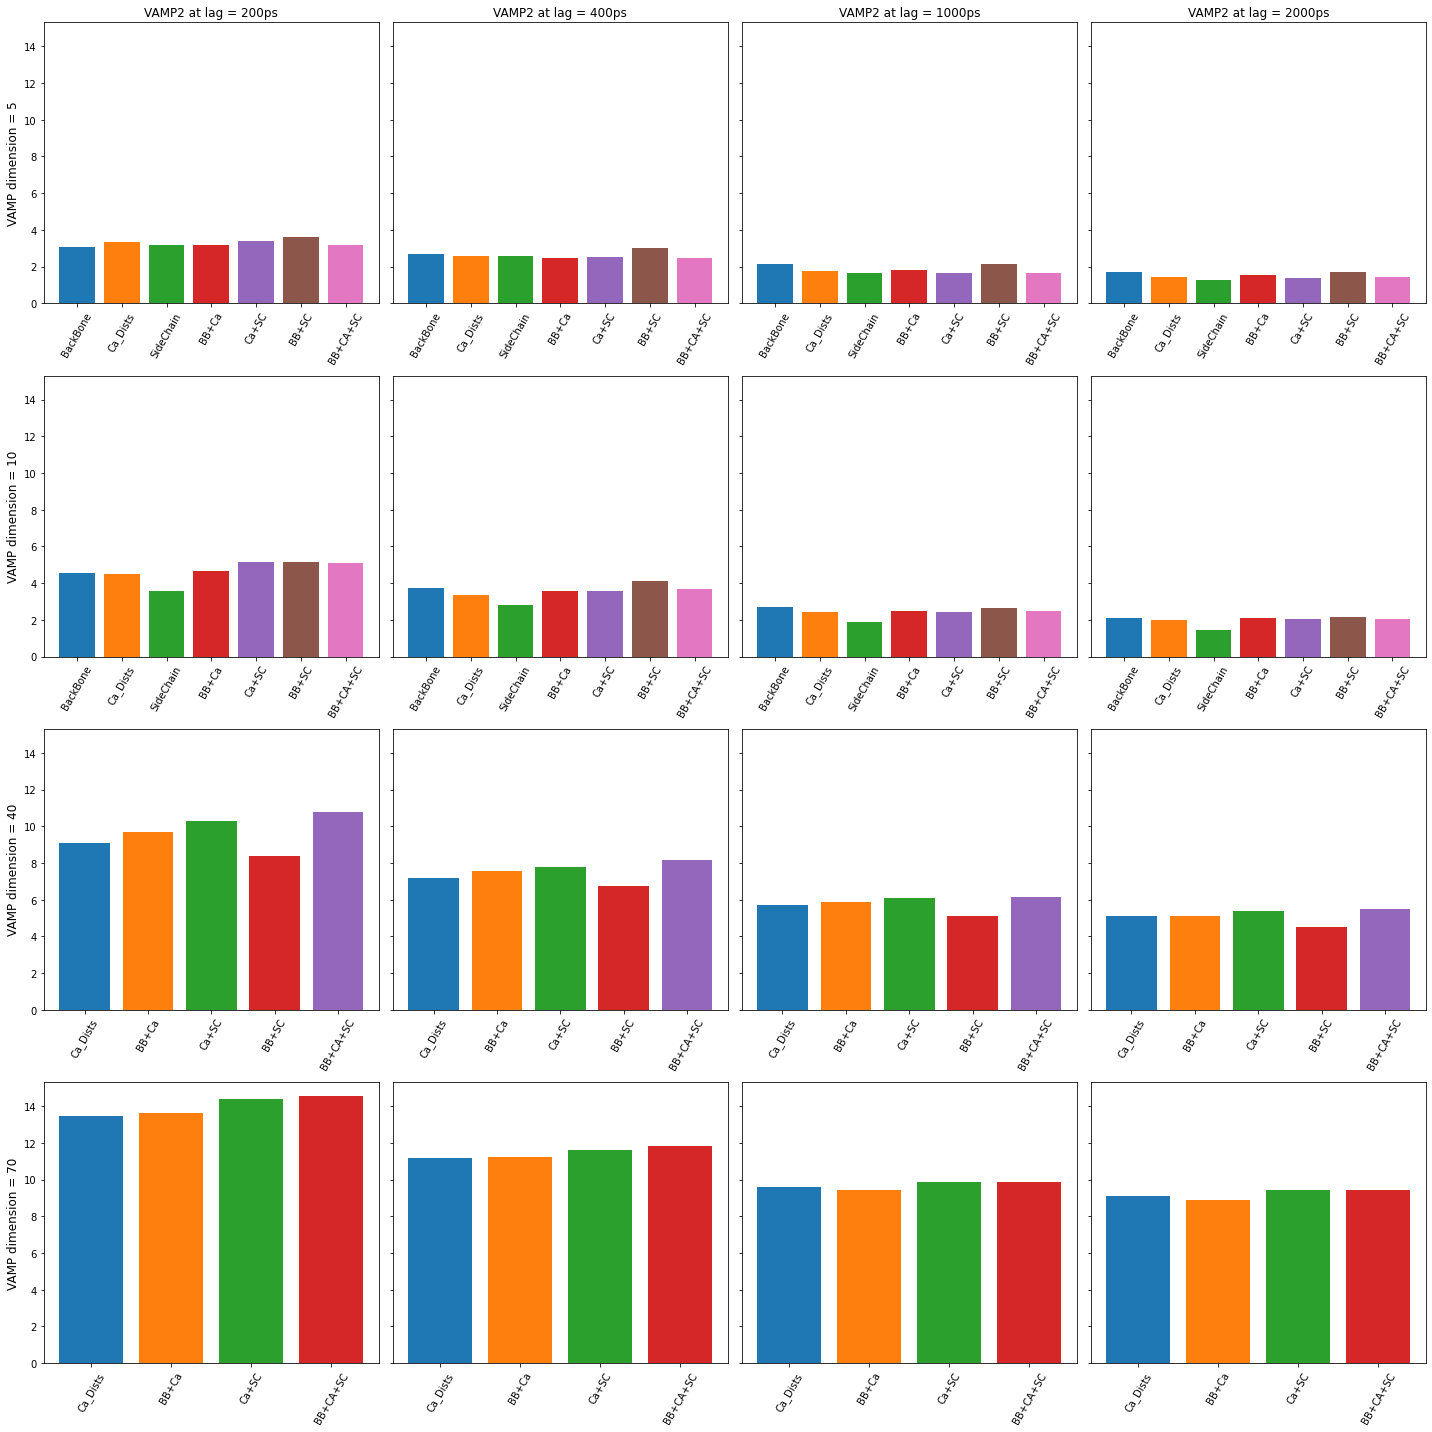

In [32]:
# Compute VAMP scores at different lag times and dimensions
# This is to ensure that our selected feature is robust as a function of lag time
# and to select features by comparing VAMP scores 

dimensions = [5, 10, 40, 70]
lagtimes = [5, 10, 25, 50]

fig, axes = plt.subplots(len(dimensions), 4, figsize=(5*len(lagtimes), 5*len(dimensions)), sharey = True)
for i, dim in enumerate(dimensions):
    for j, lag in enumerate(lagtimes):
        plot_for_lag(axes[i,j], lag, data_list, test_data_list, label_list, dim = dim)
for ax, lag in zip(axes[0], lagtimes):
    ax.set_title('VAMP2 at lag = {}ps'.format(lag*40), size = 'large')
for ax, dim in zip(axes[:,0], dimensions):
    ax.set_ylabel('VAMP dimension = {}'.format(dim), rotation = 90, size = 'large')
fig.tight_layout()
plt.savefig(fname = './figures/VAMP_scores.png')

***
### Dimensionality Reduction and Discretisation

In [5]:
# Number of orginal features = sidechain torsions (18) + ca distances (78) = 96
# Concatenate trajectories
# Perform TICA and VAMP transformation on the feature space and reduce the feature space dimensions to (60*length)

feat = pyemma.coordinates.featurizer(gro)
feat.active_features = []
feat.add_sidechain_torsions(periodic = False)
feat.add_distances_ca(periodic = False)
reader = pyemma.coordinates.source(trj, features = feat)

tica = pyemma.coordinates.tica(reader, lag = 25, var_cutoff = 0.95, stride = 3)
tica_output = tica.get_output(stride = 1)
tica_concatenated = np.concatenate(tica_output)
vamp = pyemma.coordinates.vamp(reader, lag = 25, dim = 0.95, stride = 3)
vamp_output = vamp.get_output(stride = 1)
vamp_concatenated = np.concatenate(vamp_output)
tica.save('./models/3us.pyemma', model_name = 'tica_lag_25', overwrite = True)

print('TICA subspace shape', tica_concatenated.shape)
print('VAMP subspace shape', vamp_concatenated.shape)

/home/rzhu/miniconda3/envs/pyemma_tutorials/lib/python3.9/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


Obtaining file info:   0%|                                                                        | 0/3 [00:00…

calculate covariances:   0%|                                                                      | 0/3 [00:00…

getting output of TICA:   0%|                                                                     | 0/3 [00:00…

calculate covariances:   0%|                                                                      | 0/3 [00:00…

getting output of VAMP:   0%|                                                                     | 0/3 [00:00…

12-10-22 10:24:46 pyemma._base.serialization.h5file INFO     overwriting model "tica_lag_25" in file ./models/3us.pyemma
TICA subspace shape (75003, 60)
VAMP subspace shape (75003, 61)


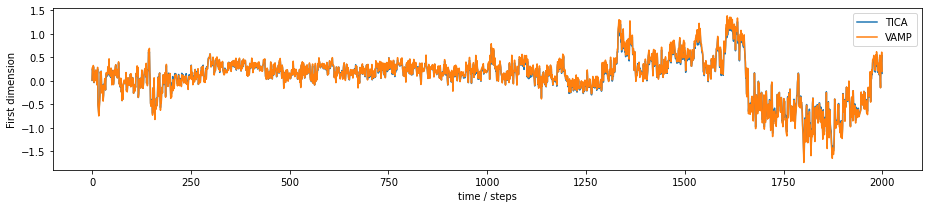

In [35]:
# TICA and VAMP performed almost the same transformation
# Plot the first IC as a time series. Does it resolve any metastability??

fig, ax = plt.subplots(figsize=(13, 3))
ax.plot(tica_concatenated[:2000,1], label = 'TICA')
ax.plot(vamp_concatenated[:2000,1], label = 'VAMP')
ax.set_xlabel('time / steps')
ax.set_ylabel('First dimension')
ax.legend()
fig.tight_layout()
plt.savefig(fname = './figures/IC_time_series.png')

In [36]:
# Clustering the TICA subspace into 300 kmeans centers
# Now each frame has been assigned to a discrete state

cluster = pyemma.coordinates.cluster_kmeans(tica, k = 300, max_iter = 100, stride = 10)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)
print(cluster.clustercenters.shape)
print(len(cluster.dtrajs), cluster.dtrajs[0].shape, dtrajs_concatenated.shape)

creating data array:   0%|                                                                        | 0/3 [00:00…

initialize kmeans++ centers:   0%|                                                              | 0/300 [00:00…

kmeans iterations:   0%|                                                                        | 0/100 [00:00…

getting output of KmeansClustering:   0%|                                                         | 0/3 [00:00…

(300, 60)
3 (25001,) (75003,)


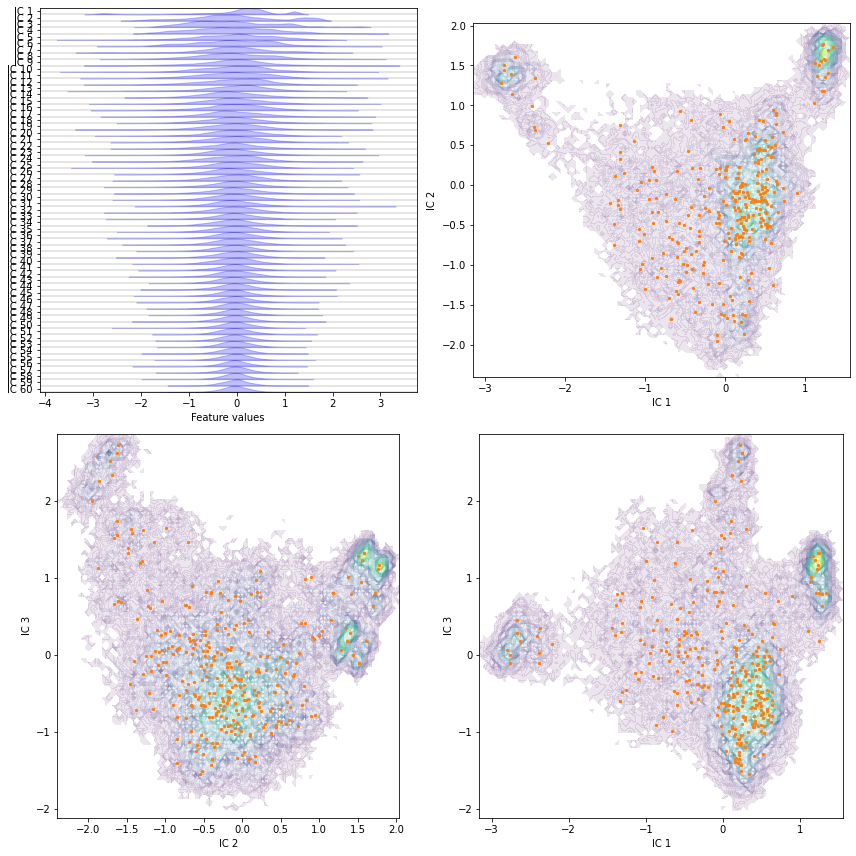

In [21]:
# Plot marginal distributions and pairwise joint distributions of the top three independent components with cluster centers

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0, 0], ignore_dim_warning=True)
for ax, (i, j) in zip(axes.flat[1:], [[0, 1], [1, 2], [0, 2]]):
    pyemma.plots.plot_density(
        *tica_concatenated[:, [i, j]].T, ax=ax, cbar=False, alpha=0.1)
    ax.scatter(*cluster.clustercenters[:, [i, j]].T, s=5, c='C1')
    ax.set_aspect('equal')
    ax.set_xlabel('IC {}'.format(i + 1))
    ax.set_ylabel('IC {}'.format(j + 1))
fig.tight_layout()
plt.savefig(fname = './figures/feature_distributions.png')

*** 
### MSM estimation and validation

estimating BayesianMSM:   0%|                                                                     | 0/7 [00:00…

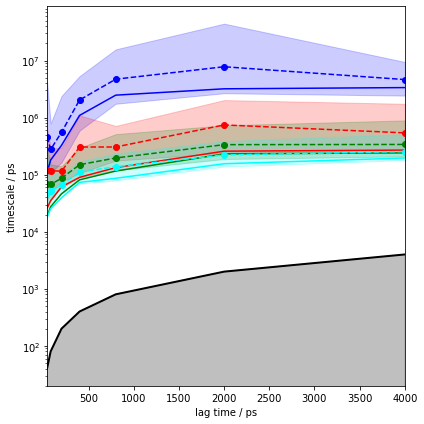

In [40]:
# Plot implied timescales as a function of lag time
# Number of ITSs is set to 4
# Each frame correspond to 40 ps

fig, ax = plt.subplots(figsize = (6,6))
its = pyemma.msm.its(cluster.dtrajs, nits = 4, lags = [1, 2, 5, 10, 20, 50, 100], errors='bayes')
pyemma.plots.plot_implied_timescales(its, units = 'ps', dt = 40, ax = ax)
ax.set_title("Top 4 ITS with 300 centers")
fig.tight_layout()
plt.savefig(fname = './figures/4ITS_300.png')

estimating BayesianMSM:   0%|                                                                     | 0/7 [00:00…

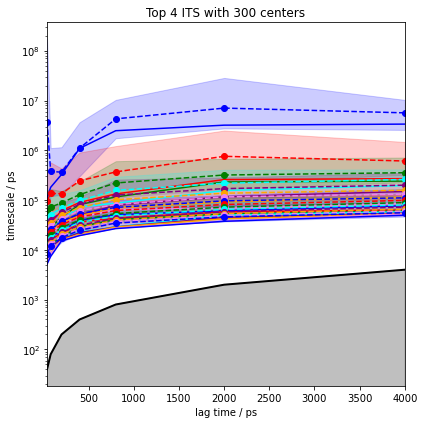

In [22]:
fig, ax = plt.subplots(figsize = (6,6))
its = pyemma.msm.its(cluster.dtrajs, nits = 15, lags = [1, 2, 5, 10, 20, 50, 100], errors='bayes')
pyemma.plots.plot_implied_timescales(its, units = 'ps', dt = 40, ax = ax)
ax.set_title("Top 15 ITS with 300 centers")
fig.tight_layout()
plt.savefig(fname = './figures/15ITS_lag300.png')

creating data array:   0%|                                                                        | 0/3 [00:00…

initialize kmeans++ centers:   0%|                                                              | 0/100 [00:00…

kmeans iterations:   0%|                                                                        | 0/200 [00:00…

getting output of KmeansClustering:   0%|                                                         | 0/3 [00:00…

estimating BayesianMSM:   0%|                                                                     | 0/7 [00:00…

creating data array:   0%|                                                                        | 0/3 [00:00…

initialize kmeans++ centers:   0%|                                                              | 0/200 [00:00…

kmeans iterations:   0%|                                                                        | 0/200 [00:00…

getting output of KmeansClustering:   0%|                                                         | 0/3 [00:00…

estimating BayesianMSM:   0%|                                                                     | 0/7 [00:00…

creating data array:   0%|                                                                        | 0/3 [00:00…

initialize kmeans++ centers:   0%|                                                              | 0/250 [00:00…

kmeans iterations:   0%|                                                                        | 0/200 [00:00…

getting output of KmeansClustering:   0%|                                                         | 0/3 [00:00…

estimating BayesianMSM:   0%|                                                                     | 0/7 [00:00…

creating data array:   0%|                                                                        | 0/3 [00:00…

initialize kmeans++ centers:   0%|                                                              | 0/400 [00:00…

kmeans iterations:   0%|                                                                        | 0/200 [00:00…

getting output of KmeansClustering:   0%|                                                         | 0/3 [00:00…

estimating BayesianMSM:   0%|                                                                     | 0/7 [00:00…

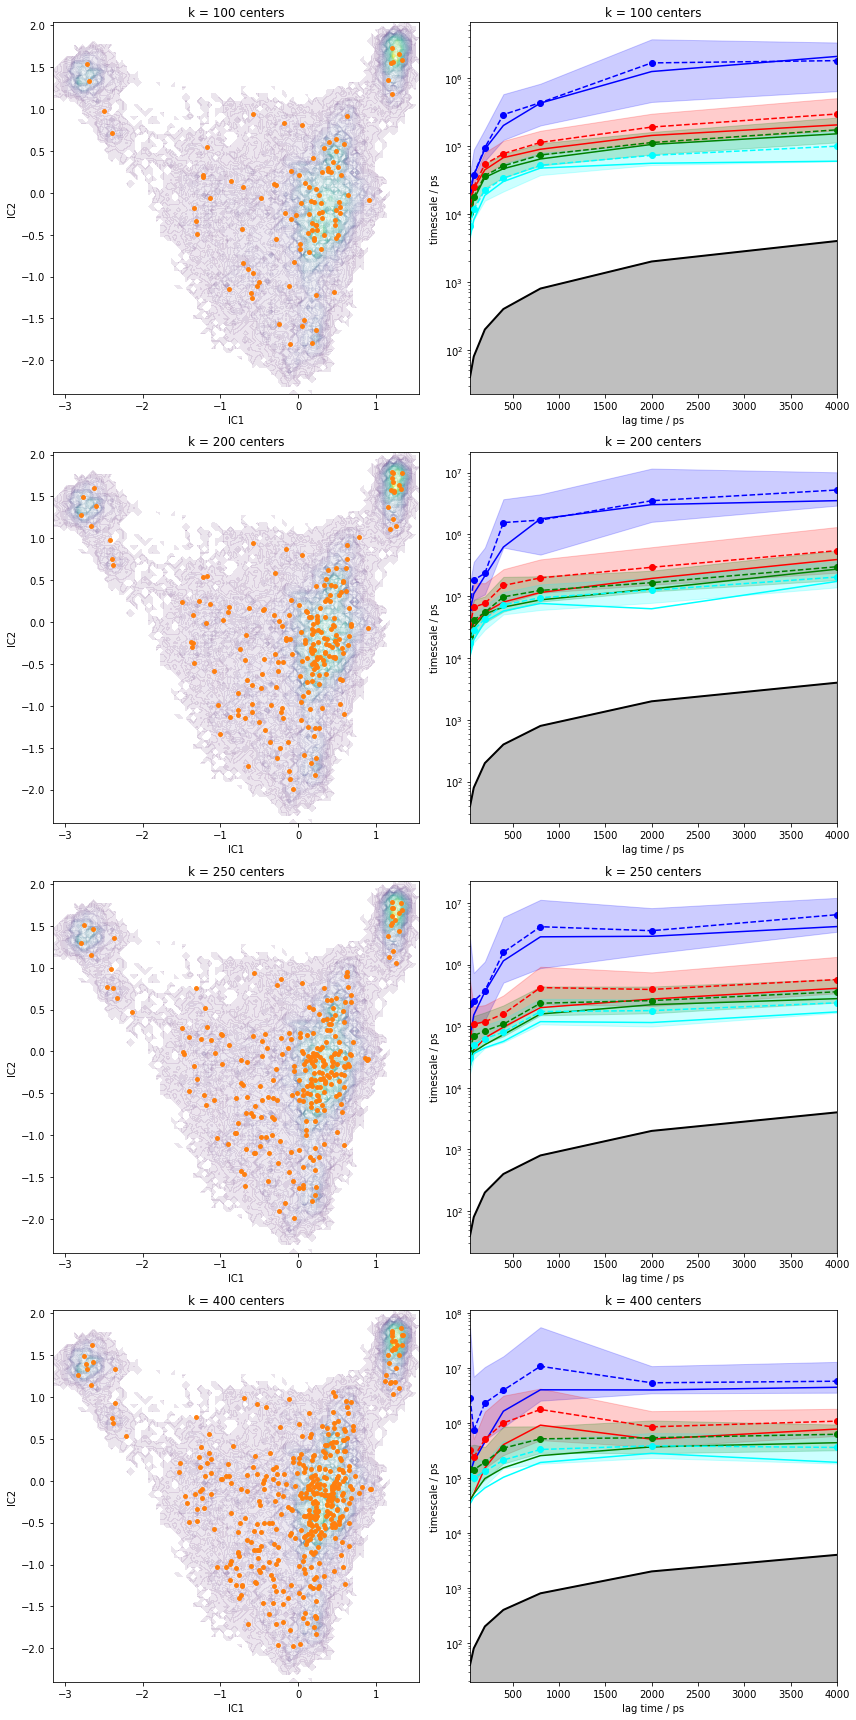

In [13]:
# ITS convergence test for different number of cluster centers

fig, axes = plt.subplots(4, 2, figsize=(12, 24))
for i, k in enumerate([100, 200, 250, 400]):
    cluster_test = pyemma.coordinates.cluster_kmeans(tica, k=k, max_iter=200, stride=10)
    pyemma.plots.plot_density(*tica_concatenated[:,:2].T, ax=axes[i, 0], cbar=False, alpha=0.1)
    axes[i, 0].scatter(*cluster_test.clustercenters[:, :2].T, s=15, c='C1')
    axes[i, 0].set_xlabel('IC1')
    axes[i, 0].set_ylabel('IC2')
    axes[i, 0].set_title('k = {} centers'.format(k))
    pyemma.plots.plot_implied_timescales(pyemma.msm.its(cluster_test.dtrajs, nits=4, lags=[1, 2, 5, 10, 20, 50, 100], errors='bayes'), 
                                         ax=axes[i, 1], units='ps', dt = 40)
    axes[i, 1].set_title('k = {} centers'.format(k))
fig.tight_layout()
plt.savefig(fname = './figures/ITS_compare.png')

In [41]:
# Estimate a maximum likelihood and a Bayesian markov model from discrete trajectories
# Save data

msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag = 25, dt_traj = '40 ps')
bayesian_msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag = 25, dt_traj='40 ps', conf = 0.95)

path = r'./models/3us.pyemma'
cluster.save(path, model_name = 'kmeans_300_cluster', overwrite = True)
msm.save(path, model_name = 'msm_lag_50', overwrite = True)
bayesian_msm.save(path, model_name = 'bayesian_msm', overwrite = True)

pyemma.msm.estimators.bayesian_msm.BayesianMSM[3140]: compute stat. inefficiencies:   0%|      | 0/3696 [00:00…

pyemma.msm.estimators.bayesian_msm.BayesianMSM[3140]: Sampling MSMs:   0%|                      | 0/100 [00:00…

estimating BayesianMSM:   0%|                                                                     | 0/9 [00:00…

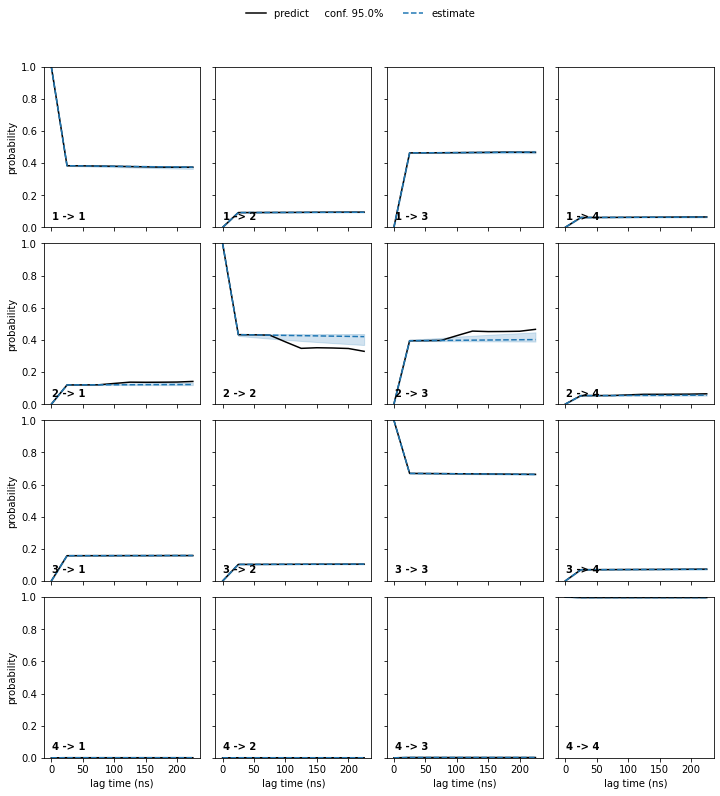

In [42]:
# Then perform a CK test to confirm whether this model satifies Markovianity
# The number of metastable states is chosen to be 4

pyemma.plots.plot_cktest(bayesian_msm.cktest(4), units='ns', figsize = (12,12))
plt.savefig(fname = './figures/CK_4states_Bayesian.png')

***
### MSM analysis

In [3]:
# Restore data

trj = glob.glob('./data/md_1us_*_noPBC.xtc')
path = r'./models/3us.pyemma'
msm = pyemma.load(path, model_name='msm_lag_50')
cluster = pyemma.load(path, model_name='kmeans_300_cluster')
dtrajs_concatenated = np.concatenate(cluster.dtrajs)
bayesian_msm = pyemma.load(path, model_name='bayesian_msm')

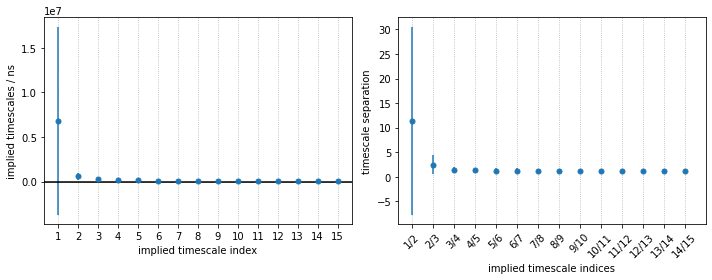

In [24]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)

nits = 15
timescales_mean = bayesian_msm.sample_mean('timescales', k=nits)
timescales_std = bayesian_msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean, 
    yerr=timescales_std, 
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:], 
    yerr=its_separation_err(
        timescales_mean, 
        timescales_std), 
    fmt='.', 
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')
    
axes[0].axhline(bayesian_msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, bayesian_msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
axes[1].set_xticklabels(
    ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits)],
    rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()

In [41]:
# Checking disconnectivity --- only largest set of reversibly connected discrete states are used in MSM estimation

print('Fraction of states used = {:f}'.format(msm.active_state_fraction))
print('Fraction of counts used = {:f}'.format(msm.active_count_fraction))
print('Inactive states which have been excluded from estimation\n', set(range(cluster.clustercenters.shape[0]))-set(msm.active_set))

Fraction of states used = 1.000000
Fraction of counts used = 1.000000
Inactive states which have been excluded from estimation
 set()


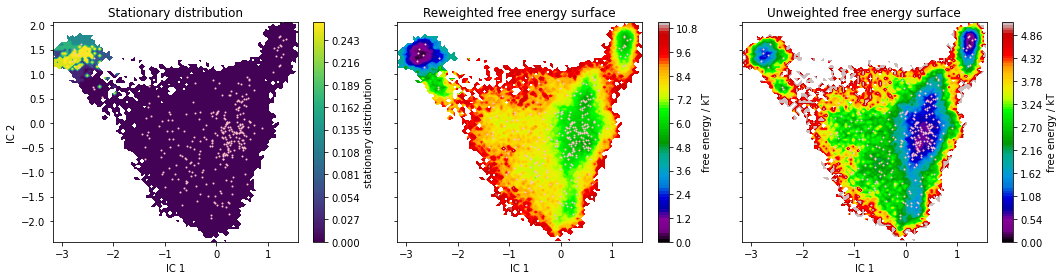

In [52]:
# Plot stationary distribution and reweighted free energy projected onto the first two dimensions

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    bayesian_msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(bayesian_msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    ax=axes[2],
    legacy=False)

for ax in axes.flat:
    ax.scatter(*cluster.clustercenters[:,:2].T, s=1, c='pink')
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution')
axes[1].set_title('Reweighted free energy surface')
axes[2].set_title('Unweighted free energy surface')
fig.tight_layout()

plt.savefig(fname = './figures/stationary_distribution_reweighted_free_energy.png')

first eigenvector is one: True (min=0.9999999999984985, max=1.0000000000090596)


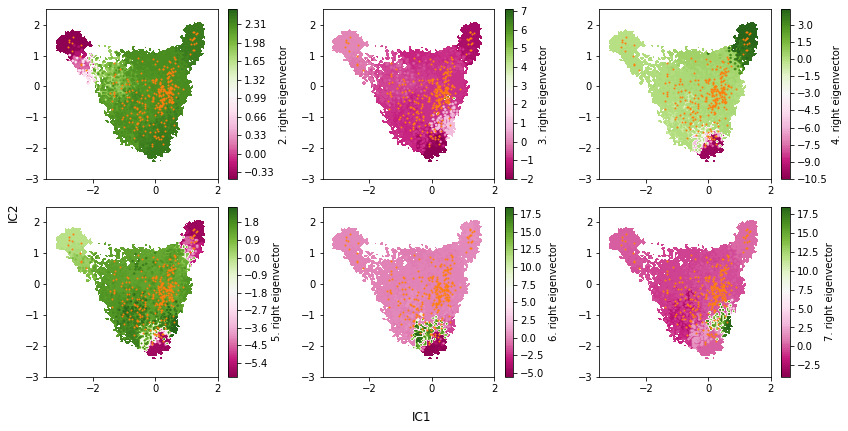

In [7]:
# Plot the top 6 right eigenvalues

eigvec = msm.eigenvectors_right()
print('First rith eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:,:2].T, eigvec[dtrajs_concatenated, i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.clustercenters[:,:2].T, s=1, c='C1')
    ax.set_xlim([-3.5,2])
    ax.set_ylim([-3,2.5])
fig.supxlabel('IC1')
fig.supylabel('IC2')
fig.tight_layout()
plt.savefig(fname = './figures/top_6_eigenvalues.png')

In [74]:
# Compute the stationary distribution of metastable states

nstates = 4
msm.pcca(nstates)
for i, s in enumerate(msm.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, msm.pi[s].sum()))

π_1 = 0.009345
π_2 = 0.129569
π_3 = 0.017625
π_4 = 0.843461


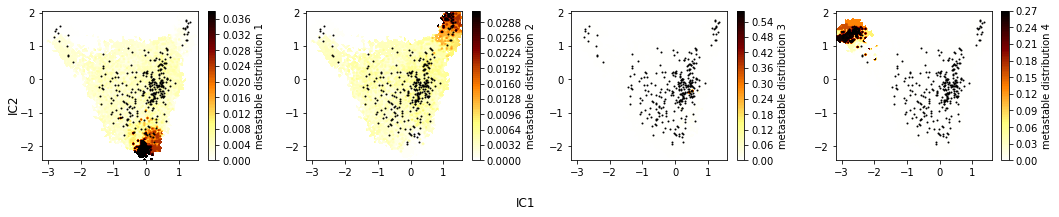

In [67]:
# Membership probability -- the probability of microstates that belong to the same macrostate
# Plot membership distribution

fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:,:2].T, msm.metastable_distributions[i][dtrajs_concatenated], ax=ax, cmap='afmhot_r', 
        mask=True, method='nearest', cbar_label='metastable distribution {}'.format(i + 1))
    ax.scatter(*cluster.clustercenters[:,:2].T, s=1, c='k')
fig.supylabel('IC2')
fig.supxlabel('IC1')
fig.tight_layout()
plt.savefig(fname = './figures/membership_distribution.png')

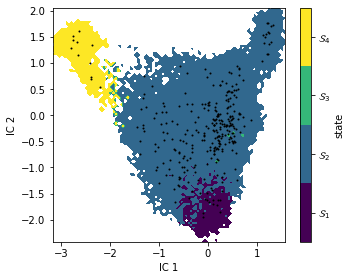

In [70]:
# Convert the membership distribution to crisp assignments

metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.scatter(*cluster.clustercenters[:,:2].T, s=1, c='k')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()
plt.savefig(fname = './figures/metastable_assignment.png')

In [4]:
# Generate a number of representative molecular structures for each metastable state

pcca_samples = msm.sample_by_distributions(msm.metastable_distributions, 10)
reader = pyemma.coordinates.source(trj, features = feat)
pyemma.coordinates.save_trajs(
    reader,
    pcca_samples,
    outfiles=['./data/pcca_{}_10samples.pdb'.format(n + 1) for n in range(msm.n_metastable)])

NameError: name 'msm' is not defined

In [76]:
def visualize_metastable(samples, cmap, selection='not element H'):
    """ visualize metastable states
    Parameters
    ----------
    samples: list of mdtraj.Trajectory objects
        each element contains all samples for one metastable state.
    cmap: matplotlib.colors.ListedColormap
        color map used to visualize metastable states before.
    selection: str
        which part of the molecule to selection for visualization. For details have a look here:
        http://mdtraj.org/latest/examples/atom-selection.html#Atom-Selection-Language
    """
    import nglview
    from matplotlib.colors import to_hex

    widget = nglview.NGLWidget()
    widget.clear_representations()
    ref = samples[0]
    for i, s in enumerate(samples):
        s = s.superpose(ref, atom_indices=s.top.select('resid 2 3 and mass > 2'))
        s = s.atom_slice(s.top.select(selection))
        comp = widget.add_trajectory(s)
        comp.add_licorice()

    # this has to be done in a separate loop for whatever reason...
    x = np.linspace(0, 1, num=len(samples))
    for i, x_ in enumerate(x):
        c = to_hex(cmap(x_))
        widget.update_licorice(color=c, component=i, repr_index=i)
        widget.remove_cartoon(component=i)
    return widget

In [81]:
my_samples = [pyemma.coordinates.save_traj(trj, idist, outfile=None, top=gro)
              for idist in msm.sample_by_distributions(msm.metastable_distributions, 50)]

cmap = mpl.cm.get_cmap('viridis', nstates)
visualize_metastable(my_samples, cmap)

Obtaining file info:   0%|                                                                        | 0/3 [00:00…

Obtaining file info:   0%|                                                                        | 0/3 [00:00…

Obtaining file info:   0%|                                                                        | 0/3 [00:00…

NGLWidget(max_frame=49)

In [68]:
# Compute mean first passage time (MFPT) -- an average timescale for a transition event to first occur

mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

print('MFPT / steps:')
pd.DataFrame(np.round(mfpt, decimals=1), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / steps:


,1,2,3,4
1,0.00,130791.62,15630986.97,2313423.70
2,12781371.71,0.00,15490615.81,2155650.11
3,13325362.66,312681.06,0.00,2457508.80
4,29381314.45,13625568.60,31831177.37,0.00
